# Background

- Suppose that we are statistical consultants hired by a client to investigate the association between advertising and sales of a particular product.
- We are provided the dataset consists of the **sales** of one particular product in 200 diferent markets, along with advertising budgets for the product in each of those markets for three diferent media: **TV**, **Radio**, and **newspaper**.
- Client has **full control** of advertising expenses in each of the three media.
- If we determine that there is an association between advertising and alses, then we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales.
- **OBJECTIVE**: Our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

# Import Modules

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# Load Dataset

- '**Unnamed: 0**': additional index(Confirmed with Client, and we can drop it)
- '**TV**': TV Advertising Spends, and unit is in thousands of dollars.
- '**Radio**': Radio Advertising Spends, and unit is in thousand of dollars.
- '**Newspaper**':Newspaper Advertising Spends, and unit is in thousand of dollars.
- '**Sales**':The quantities of product sale at corresponding budget of three advertising approaches, and unit is in thousand of dollars(Notice is not dollars).

In [3]:
df = pd.read_csv('Advertising.csv')
# drop feature 'Unnamed:0'
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


# Check Noise and Denoise

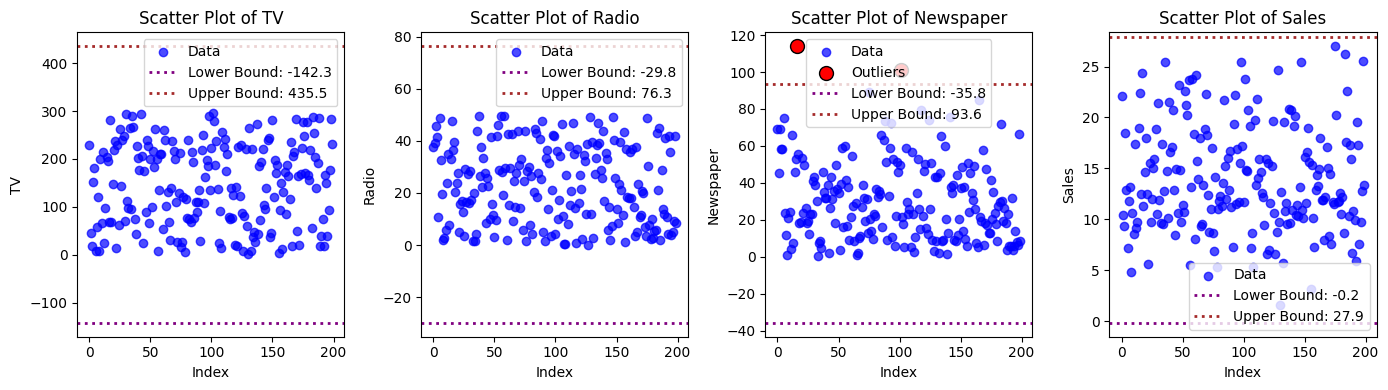

In [5]:
plt.figure(figsize=(14, 4))

for i, feature in enumerate(df.columns):
    # Calculate IQR-based noise (outliers)
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
    
    # Create subplot
    plt.subplot(1, 4, i + 1)

    # Scatter plot for all data points
    plt.scatter(df.index, df[feature], color='blue', label='Data', alpha=0.7)

    # Highlight outliers in red
    if not outliers.empty:
        plt.scatter(outliers.index, outliers, color='red', edgecolors='black', s=100, label='Outliers')

    # Plot IQR bounds
    plt.axhline(lower_bound, color='purple', linestyle='dotted', linewidth=2, label=f'Lower Bound: {lower_bound:.1f}')
    plt.axhline(upper_bound, color='brown', linestyle='dotted', linewidth=2, label=f'Upper Bound: {upper_bound:.1f}')
    
    # Labels and title
    plt.xlabel("Index")
    plt.ylabel(f"{feature}")
    plt.title(f"Scatter Plot of {feature}")
    plt.legend()

# Show scatter plots
plt.tight_layout()
plt.show()

In [6]:
df = df[df['Newspaper'] <= 93.6]

# Data Visualization

- TV Spend and Radio Spend has a postive correlation with Sales
- The positive correlation between TV Spend and Radio Spend is strong

TV Correlation: 0.779
Radio Correlation: 0.577
Newspaper Correlation: 0.220


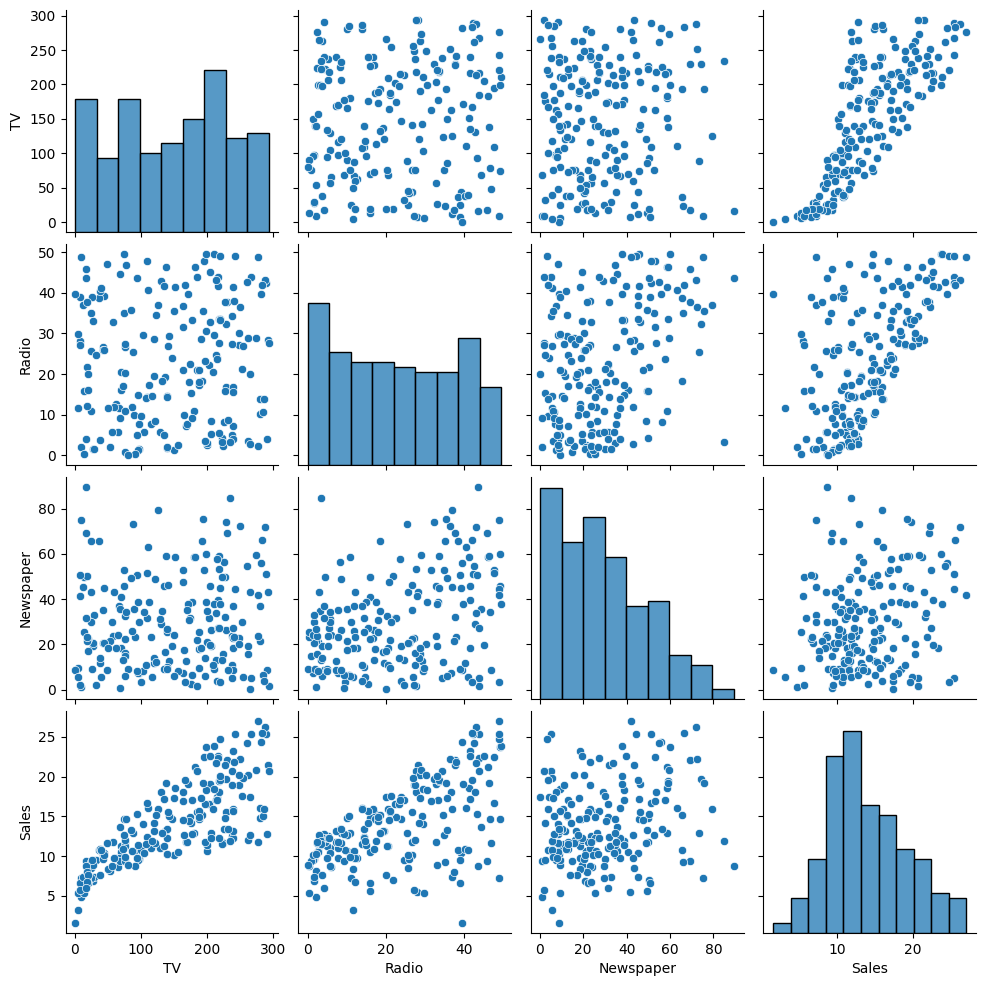

In [7]:
sns.pairplot(df)
tv_corr = df['TV'].corr(df['Sales'])
radio_corr = df['Radio'].corr(df['Sales'])
np_corr = df['Newspaper'].corr(df['Sales'])
print(f"TV Correlation: {tv_corr:.3f}")
print(f"Radio Correlation: {radio_corr:.3f}")
print(f"Newspaper Correlation: {np_corr:.3f}")
plt.show()

# Linear Regression

We will calculate the most optimized coefficient by doing multiple approach:
- Manually calculating Ordinary Least Square(OLS).
- NumPy
- Scikit-Learn

## Manually Calculate OLS

In [8]:
def OLS(feature, predict):
    X = df[feature]
    y = df[predict]
    x_mean = X.mean()
    y_mean = y.mean()

    df['x_diff'] = X - x_mean
    df['y_diff'] = y - y_mean
    df['mult'] = df['x_diff'] * df['y_diff']
    df['x_diff_square'] = df['x_diff'] ** 2

    B1_slope = df['mult'].sum() / df['x_diff_square'].sum()
    B0_Intercept = y_mean - B1_slope * x_mean

    # Drop the temporary columns
    df.drop(columns=['x_diff', 'y_diff', 'mult', 'x_diff_square'], inplace=True)

    return B0_Intercept, B1_slope

def predict_sales(feature_value,B0, B1):
    return B0 + B1 * feature_value

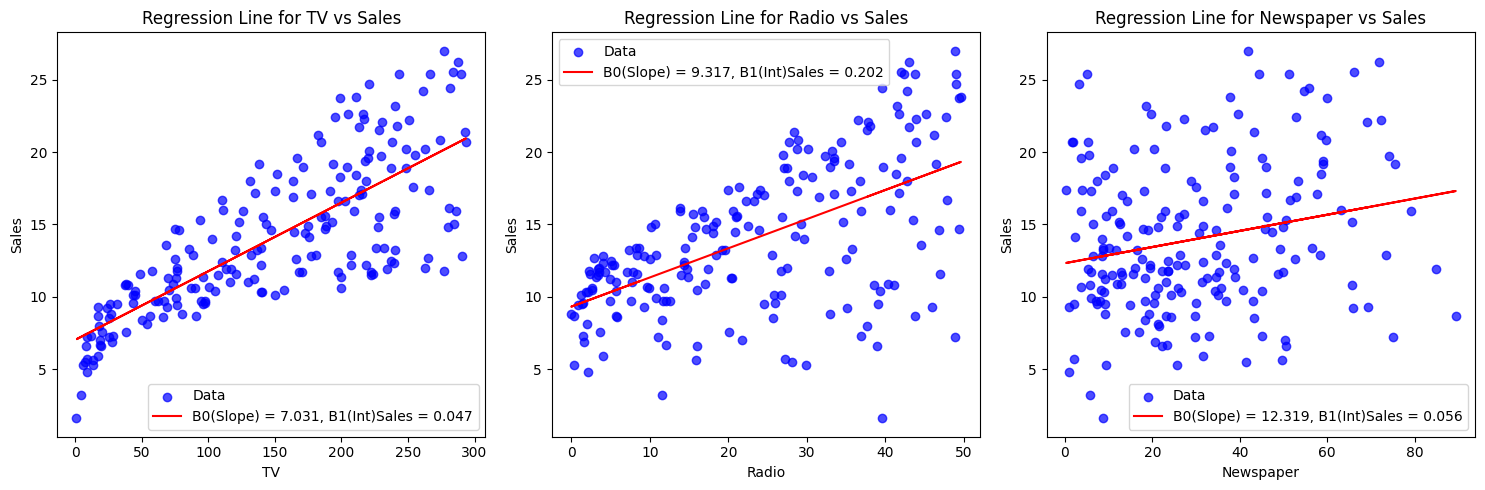

In [13]:
plt.figure(figsize=(15, 5))
for i, feature in enumerate(df.columns):
    if feature != 'Sales':
        B0, B1 = OLS(feature, 'Sales')
        plt.subplot(1, 3, i + 1)
        plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
        equation_label = f"B0(Slope) = {B0:.3f}, B1(Int)Sales = {B1:.3f}"
        plt.plot(df[feature], B0 + B1 * df[feature], color='red', label=equation_label)
        plt.xlabel(f'{feature}')
        plt.ylabel('Sales')
        plt.title(f'Regression Line for {feature} vs Sales')
        plt.legend()
plt.tight_layout()
plt.show()

## NumPy

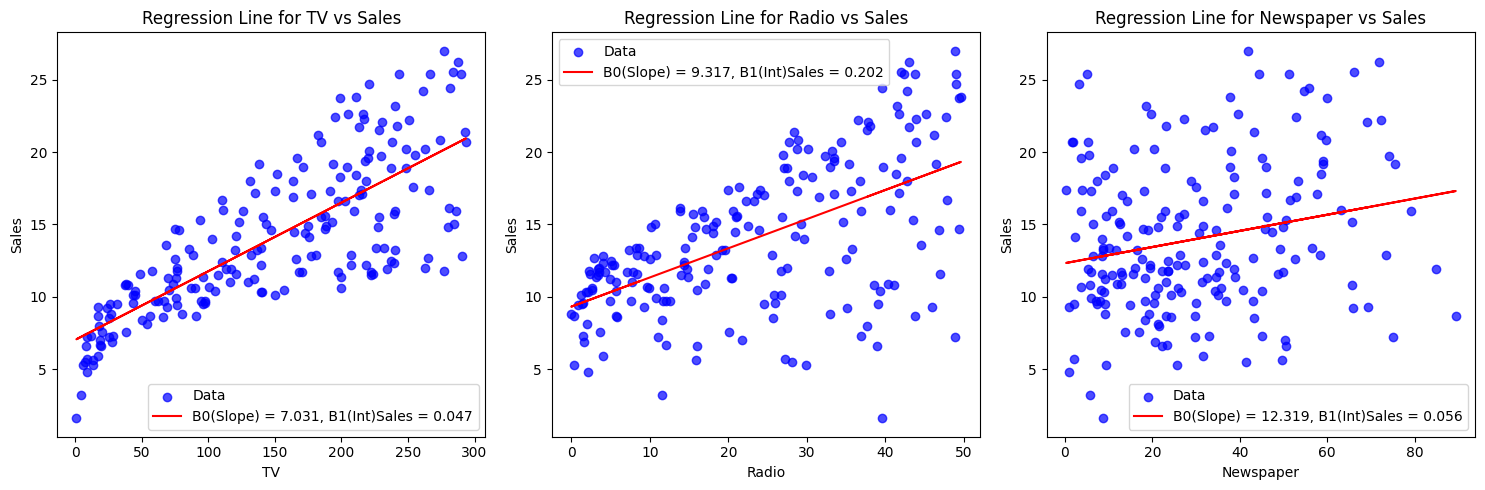

In [15]:
plt.figure(figsize=(15, 5))
y = df['Sales']
for i, feature in enumerate(df.columns):
    if feature != 'Sales':
        X = df[feature]
        B1, B0 = np.polyfit(X,y,deg=1) # sovling 1st degree polynomial function to find B1 and B0
        plt.subplot(1, 3, i + 1)
        plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
        equation_label = f"B0(Slope) = {B0:.3f}, B1(Int)Sales = {B1:.3f}"
        plt.plot(df[feature], B0 + B1 * df[feature], color='red', label=equation_label)
        plt.xlabel(f'{feature}')
        plt.ylabel('Sales')
        plt.title(f'Regression Line for {feature} vs Sales')
        plt.legend()
plt.tight_layout()
plt.show()

## Scikit-Learning

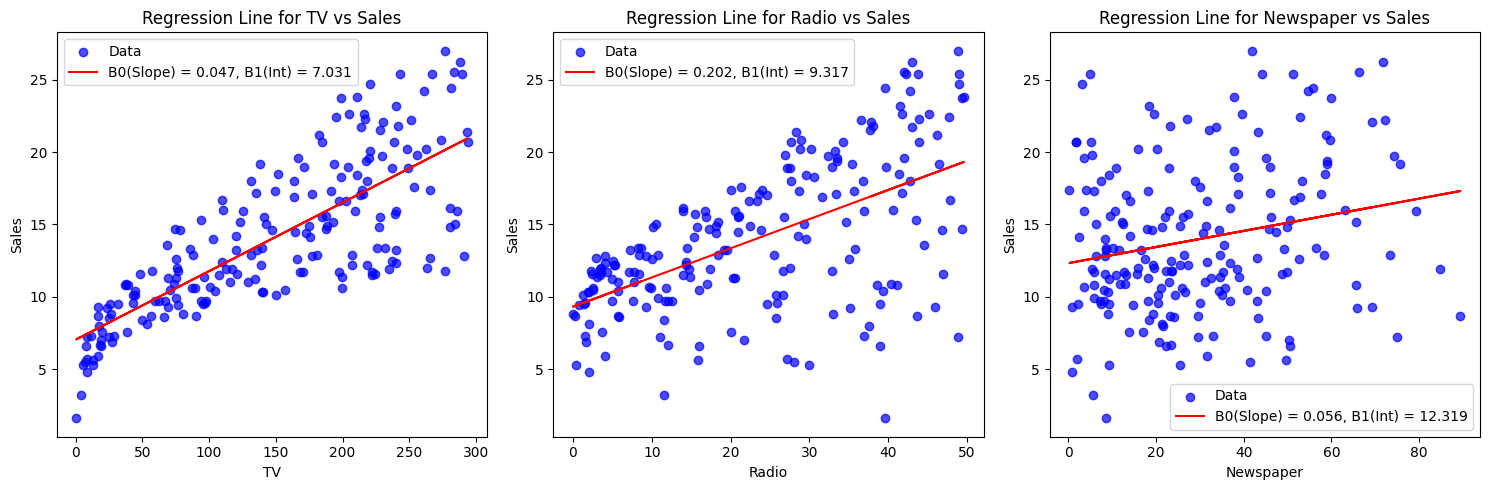

In [18]:
plt.figure(figsize=(15, 5))
y = df['Sales']

for i, feature in enumerate(df.columns):
    if feature != 'Sales':
        X = df[[feature]]  # 2D shape required for sklearn
        model = LinearRegression()
        model.fit(X, y)

        B0 = model.intercept_
        B1 = model.coef_[0]

        plt.subplot(1, 3, i + 1)
        plt.scatter(df[feature], y, color='blue', label='Data', alpha=0.7)

        equation_label = f"B0(Slope) = {B1:.3f}, B1(Int) = {B0:.3f}"
        plt.plot(df[feature], model.predict(X), color='red', label=equation_label)

        plt.xlabel(f'{feature}')
        plt.ylabel('Sales')
        plt.title(f'Regression Line for {feature} vs Sales')
        plt.legend()

plt.tight_layout()
plt.show()